<a href="https://colab.research.google.com/github/maribecrurod-art/Bootstrap-Proyect/blob/main/Conv2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capa Conv2D


## 1) Concepto y definición


**Una capa convolucional 2D (también llamada Conv2D) es el bloque principal de una red neuronal convolucional (CNN) cuando se trabaja con imágenes o datos que tienen dos dimensiones espaciales (alto y ancho).**

**En términos simples, es una capa que aplica filtros (kernels) bidimensionales para extraer patrones locales de una imagen, como bordes, texturas o formas.**


Operación (correlación cruzada usada por la mayoría de frameworks de DL):


$$
(I ⋆ K)[i,j] = \sum_{u=0}^{k_h-1} \sum_{v=0}^{k_w-1} I[i+u, j+v] * K[u, v]
$$

(Esta es la conv. que usan los frameworks sin voltear el kernel.)

In [ ]:
#  Tamaño de salida
import numpy as np

def output_size(H, W, k_h, k_w, s_h=1, s_w=1, padding='valid'):  #Calcula el tamaño de la matriz de mapeo
    if padding == 'valid':                                       #valid indica que no se considera los bordes
        Hout = (H - k_h)//s_h + 1
        Wout = (W - k_w)//s_w + 1
    elif padding == 'same':
        Hout = int(np.ceil(H / s_h))
        Wout = int(np.ceil(W / s_w))
    else:
        raise ValueError('padding debe ser valid o same')
    return Hout, Wout

print('Ejemplo: entrada 5x4, kernel 3x3 ->', output_size(5,4,3,3))

Ejemplo: entrada 5x4, kernel 3x3 -> (3, 2)


## 3) Ejemplo con matriz 5×4 y kernel 3×3 — cálculo manual

Imagen (5×4):

```
I = [[1,2,3,0],
     [0,1,2,3],
     [1,0,1,2],
     [2,1,0,1],
     [0,2,1,0]]
```

Kernel (vertical edge detector):

```
K = [[1,0,-1],
     [1,0,-1],
     [1,0,-1]]
```

Con padding='valid' y stride=1, salida 3×2.


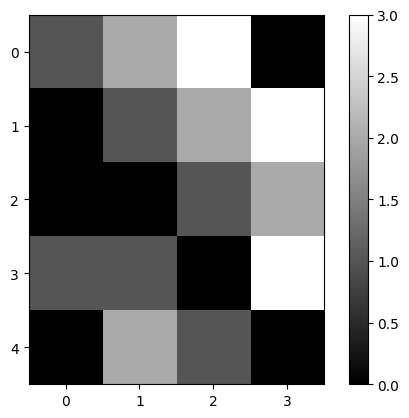

In [ ]:
import matplotlib.pyplot as plt
t = np.array([[1,2,3,0],
              [0,1,2,3],
              [0,0,1,2],
              [1,1,0,3],
              [0,2,1,0]], dtype=float)

plt.imshow(t, cmap='gray')  # sin vmin ni vmax
plt.colorbar()
plt.show()

I:
 [[1. 2. 3. 0.]
 [3. 1. 2. 3.]
 [3. 0. 1. 2.]
 [2. 1. 0. 1.]
 [1. 2. 1. 0.]]


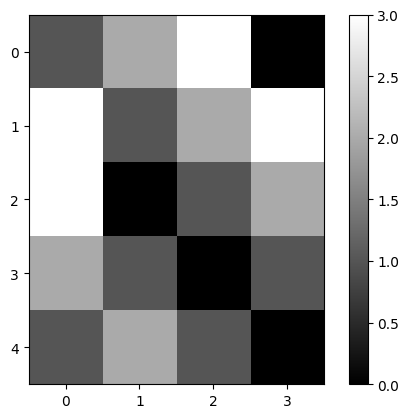


K:
 [[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]]

Parche P en (0,0):
 [[1. 2. 3.]
 [3. 1. 2.]
 [3. 0. 1.]]


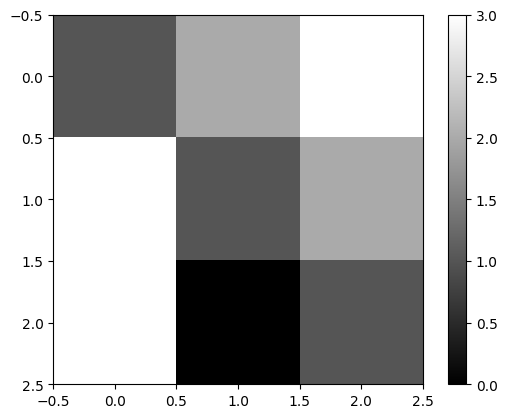


P * K =
 [[ 1.  0. -3.]
 [ 3.  0. -2.]
 [ 3.  0. -1.]]

Suma total (salida en (0,0)): 1.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

I = np.array([[1,2,3,0],
              [3,1,2,3],
              [3,0,1,2],
              [2,1,0,1],
              [1,2,1,0]], dtype=float)

K = np.array([[1,0,-1],
              [1,0,-1],
              [1,0,-1]], dtype=float)



print('I:\n', I)
plt.imshow(I, cmap='gray')  # sin vmin ni vmax
plt.colorbar()
plt.show()
print('\nK:\n', K)

# cálculo manual para posición (0,0)
P = I[0:3, 0:3]
print('\nParche P en (0,0):\n', P)
plt.imshow(P, cmap='gray')  # sin vmin ni vmax
plt.colorbar()
plt.show()
print('\nP * K =\n', P * K)
print('\nSuma total (salida en (0,0)):', np.sum(P * K))

## 4) Implementación NumPy (correlación cruzada) — single-channel y multi-channel

In [ ]:
def conv2d_cross_correlation_single_channel(image, kernel, stride=(1,1), padding='valid'):
    h, w = image.shape
    kh, kw = kernel.shape
    sh, sw = stride
    if padding == 'same':
        pad_h = max((kh - 1), 0)
        pad_w = max((kw - 1), 0)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        image_padded = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
    else:
        image_padded = image

    out_h = (image_padded.shape[0] - kh) // sh + 1
    out_w = (image_padded.shape[1] - kw) // sw + 1
    out = np.zeros((out_h, out_w), dtype=float)
    for i in range(out_h):
        for j in range(out_w):
            patch = image_padded[i*sh : i*sh + kh, j*sw : j*sw + kw]
            out[i,j] = np.sum(patch * kernel)
    return out

out_manual = conv2d_cross_correlation_single_channel(I, K)
print('Salida NumPy (manual):\n', out_manual)

Salida NumPy (manual):
 [[ 1. -2.]
 [ 5. -4.]
 [ 4.  0.]]


**La matriz resultante es un mapa de activación que indica dónde el kernel detecta bordes y en qué dirección.**

Valores negativos → el kernel detecta una transición de alto a bajo en el borde vertical.

Valores positivos → transición de bajo a alto.

Valores cercanos a 0 → poca o ninguna diferencia vertical en ese parche.

## 5) Verificación con TensorFlow




In [ ]:
import tensorflow as tf
import numpy as np

input_tensor= np.expand_dims(I, axis=(0, -1)).astype(np.float32)  #agrega dimensiones extra para cumplir con la forma que Conv2D espera: (batch, height, width, channels):
conv = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding='valid', use_bias=False) #no suma sesgo para coincidir en cuentas
_ = conv(tf.constant(input_tensor)) #Se “llama” a la capa con la entrada para inicializar los pesos internamente.
kernel_tf = K.reshape((3,3,1,1)).astype(np.float32)    #ambia la forma a (altura, ancho, canales de entrada, canales de salida)    #asegura compativilidad con tensorflow
conv.set_weights([kernel_tf])  #pesos aleatorios
out_tf = conv(tf.constant(input_tensor)).numpy()[0,:,:,0]
print('Salida TensorFlow Conv2D:\n', out_tf)

Salida TensorFlow Conv2D:
 [[ 1. -2.]
 [ 5. -4.]
 [ 4.  0.]]


## 6) Ejemplo en PyTorch

In [ ]:
try:
    import torch
    import torch.nn as nn
    torch_available = True
except Exception as e:
    torch = None
    torch_available = False
    print('PyTorch no disponible:', e)

if torch_available:
    input_t = torch.tensor(I, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    conv_t = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), bias=False, padding=0)
    with torch.no_grad():
        conv_t.weight.copy_(torch.tensor(K.reshape((1,1,3,3)), dtype=torch.float32))
    out_t = conv_t(input_t).squeeze().detach().numpy()
    print('Salida PyTorch Conv2d:\n', out_t)
    print('Diferencia máxima con NumPy:', np.max(np.abs(out_manual - out_t)))
else:
    print('Se omitió verificación con PyTorch.')

Salida PyTorch Conv2d:
 [[ 1. -2.]
 [ 5. -4.]
 [ 4.  0.]]
Diferencia máxima con NumPy: 0.0


## 7) Filtros clásicos: Sobel y Gaussian — definición y aplicación

In [ ]:
Sobel_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=float)
Sobel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=float)
G3 = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype=float)
G3 = G3 / np.sum(G3)

print('Sobel_x:\n', Sobel_x)
print('\nSobel_y:\n', Sobel_y)
print('\nGaussian 3x3 normalizado:\n', G3)

sobel_x_out = conv2d_cross_correlation_single_channel(I, Sobel_x)
sobel_y_out = conv2d_cross_correlation_single_channel(I, Sobel_y)
gauss_out = conv2d_cross_correlation_single_channel(I, G3)

print('\nSobel X salida:\n', sobel_x_out)
print('\nSobel Y salida:\n', sobel_y_out)
print('\nGaussian salida:\n', gauss_out)

Sobel_x:
 [[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]]

Sobel_y:
 [[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]

Gaussian 3x3 normalizado:
 [[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]

Sobel X salida:
 [[ 2. -4.]
 [ 7. -6.]
 [ 6.  0.]]

Sobel Y salida:
 [[ 4.  4.]
 [ 3.  6.]
 [-2.  0.]]

Gaussian salida:
 [[1.625  1.75  ]
 [1.1875 1.125 ]
 [1.125  0.75  ]]


## 8) Visualizaciones: gráficos y animación simple

Se muestran la imagen original, resultados y una animación de la ventana deslizante (si el entorno lo permite).

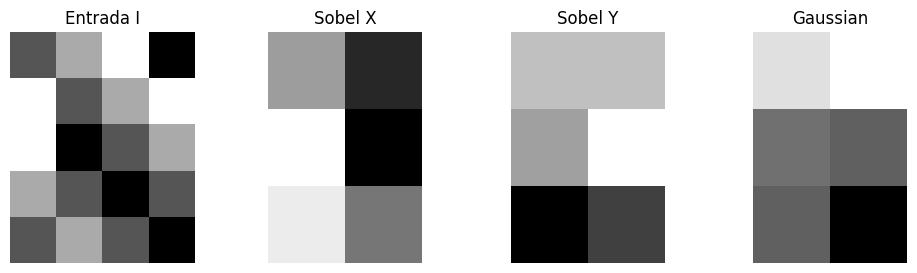

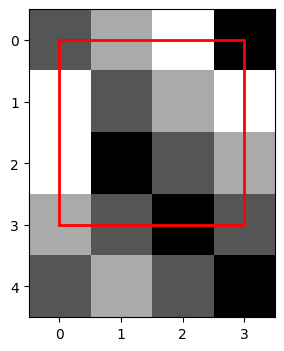

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

# Visualización estática
fig, axs = plt.subplots(1,4, figsize=(12,3))
axs[0].imshow(I, cmap='gray', interpolation='nearest')
axs[0].set_title('Entrada I')
axs[1].imshow(sobel_x_out, cmap='gray', interpolation='nearest')
axs[1].set_title('Sobel X')
axs[2].imshow(sobel_y_out, cmap='gray', interpolation='nearest')
axs[2].set_title('Sobel Y')
axs[3].imshow(gauss_out, cmap='gray', interpolation='nearest')
axs[3].set_title('Gaussian')
for a in axs:
    a.axis('off')
plt.show()

# Animación ventana deslizante
fig2, ax2 = plt.subplots(figsize=(4,4))
ax2.imshow(I, cmap='gray', interpolation='nearest')
rect = plt.Rectangle((0,0), 3, 3, edgecolor='red', facecolor='none', linewidth=2)
ax2.add_patch(rect)
text = ax2.text(0, -0.5, '', fontsize=12)

out_shape = out_manual.shape
positions = [(i,j) for i in range(out_shape[0]) for j in range(out_shape[1])]

def init():
    rect.set_xy((0,0))
    text.set_text('')
    return rect, text

def animate(k):
    i,j = positions[k]
    rect.set_xy((j, i))
    patch = I[i:i+3, j:j+3]
    val = np.sum(patch * K)
    text.set_text(f'pos=({i},{j}), val={val:.1f}')
    return rect, text

anim = animation.FuncAnimation(fig2, animate, init_func=init, frames=len(positions), interval=700, blit=False)

# intentar mostrar inline
try:
    display(HTML(anim.to_jshtml()))
except Exception as e:
    print('No se pudo renderizar la animación inline:', e)
    # guardar como GIF si no es posible mostrar
    gif_path = '/mnt/data/conv_window_animation.gif'
    try:
        anim.save(gif_path, writer='imagemagick', fps=1)
        print('Guardado como', gif_path)
    except Exception as e2:
        print('No se pudo guardar la animación como GIF:', e2)

## 9) Aplicaciones, ventajas y desventajas

**Aplicaciones:** clasificación, detección, segmentación, superresolución, extracción de características, etc.

**Ventajas:** menos parámetros que capas densas, extraen patrones locales, eficientes en GPU.

**Desventajas:** requieren datos, no invariancia a rotación/escala sin transformaciones adicionales, interpretabilidad limitada en redes profundas.

Valores negativos → el kernel detecta una transición de alto a bajo en el borde vertical.

Valores positivos → transición de bajo a alto.

Valores cercanos a 0 → poca o ninguna diferencia vertical en ese parche.

---
#Aplicación para problema de clasificación de flechas binarias
---

- Usamos **NumPy** para generar matrices y **TensorFlow/Keras** para el modelo.
- Fijamos semilla para reproducibilidad.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

labels = ['ARRIBA', 'ABAJO', 'IZQUIERDA', 'DERECHA']


#Construimos plantillas de 9×9 con 0 = fondo y 1 = flecha.

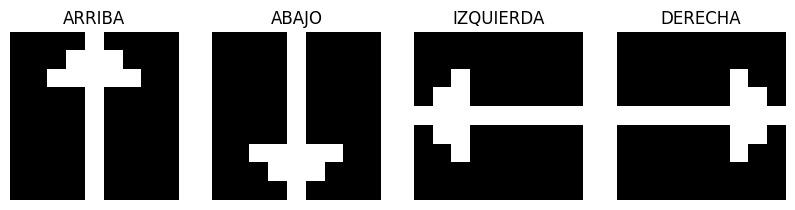

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["ARRIBA", "ABAJO", "IZQUIERDA", "DERECHA"]

def arrow_up_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    # Punta hacia arriba
    A[0,4] = 1
    A[1,3:6] = 1
    A[2,2:7] = 1
    # Tallo vertical
    A[3:,4] = 1
    return A

def arrow_down_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    # Punta hacia abajo
    A[8,4] = 1
    A[7,3:6] = 1
    A[6,2:7] = 1
    # Tallo vertical
    A[:6,4] = 1
    return A

def arrow_left_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    # Punta hacia la izquierda
    A[4,0] = 1
    A[3:6,1] = 1
    A[2:7,2] = 1
    # Tallo horizontal
    A[4,3:] = 1
    return A

def arrow_right_9x9():
    A = np.zeros((9,9), dtype=np.uint8)
    # Punta hacia la derecha
    A[4,8] = 1
    A[3:6,7] = 1
    A[2:7,6] = 1
    # Tallo horizontal
    A[4,:6] = 1
    return A

# Visualización de prueba
templates = [arrow_up_9x9(), arrow_down_9x9(), arrow_left_9x9(), arrow_right_9x9()]
fig, axs = plt.subplots(1,4, figsize=(10,3))
for i, A in enumerate(templates):
    axs[i].imshow(A, cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(labels[i])
    axs[i].axis('off')
plt.show()

# Generamos ahora datos con variaciones:

In [ ]:
def shift_image(img, dx, dy): #desplaza la imagen
    H, W = img.shape
    B = np.zeros_like(img)
    xs = max(0, dx); xe = W + min(0, dx)
    ys = max(0, dy); ye = H + min(0, dy)
    B[ys:ye, xs:xe] = img[ys-dy:ye-dy, xs-dx:xe-dx]
    return B

def add_binary_noise(img, p=0.01): #agrega ruido
    # Con prob p, flip de bit (0->1, 1->0)
    flip = (np.random.rand(*img.shape) < p).astype(np.uint8)
    return np.bitwise_xor(img, flip)

def gen_dataset(templates, per_class=200, shifts=(-1,0,1), noise_p=0.01): #Genera imagenes con variación
    X, y = [], []
    for class_id, T in enumerate(templates):
        for _ in range(per_class):
            dx = np.random.choice(shifts)
            dy = np.random.choice(shifts)
            A = shift_image(T, dx, dy)
            A = add_binary_noise(A, p=noise_p)
            X.append(A)
            y.append(class_id)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    return X, y

X, y = gen_dataset(templates, per_class=300, shifts=(-1,0,1), noise_p=0.02) #genera las 12000 imagenes
X = X[..., np.newaxis]  # (N, 9, 9, 1)
y_cat = to_categorical(y, num_classes=4)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y) #divide en datos de entrenamiento y testeo
X_train.shape, X_test.shape

((960, 9, 9, 1), (240, 9, 9, 1))

## Modelo Conv2D (Keras)
- **Conv2D(8, 3×3, ReLU)**: Detecta patrones locales (puntas, tallos)
- **Conv2D(8, 3×3, ReLU)**: Compone patrones (punta + tallo)
- **Flatten + Dense(16, ReLU)**: Combina características
- **Dense(4, softmax)**: Predice una de las 4 clases

La estructura del código en Keras para usar una capa Conv2D es la siguiente:



```
model.add(Conv2D(
    filters=8,          # Número de filtros (kernels)
    kernel_size=(3,3),  # Tamaño del filtro
    activation='relu',  # Función de activación
    input_shape=(28,28,1),  # Tamaño de la imagen (alto, ancho, canales)
    padding='valid'     # Puede ser 'valid' o 'same'
))
```



In [ ]:
model = Sequential([
    Conv2D(8,
          (3,3),
          activation='relu',
          input_shape=(9,9,1),
          padding='valid'),
    Conv2D(8,
          (3,3),
          activation='relu',
          padding='valid'),
    Flatten(), #transforma los mapas de características 3D a un vector 1D para la capa densa
    Dense(16, activation='relu'), #aprende relaciones globales entre todas las características.
    Dropout(0.1), #evita que el modelo dependa demasiado de neuronas específicas.
    Dense(4, activation='softmax') #transforma la salida en probabilidades de cada clase.
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,948 (15.42 KB)

 Trainable params: 3,948 (15.42 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nExactitud en test: {test_acc*100:.2f}%")


Epoch 1/25
30/30 - 2s - 75ms/step - accuracy: 0.4917 - loss: 1.2266 - val_accuracy: 0.7167 - val_loss: 1.0155
Epoch 2/25
30/30 - 0s - 6ms/step - accuracy: 0.8344 - loss: 0.6742 - val_accuracy: 0.9875 - val_loss: 0.2961
Epoch 3/25
30/30 - 0s - 6ms/step - accuracy: 0.9542 - loss: 0.2127 - val_accuracy: 1.0000 - val_loss: 0.0719
Epoch 4/25
30/30 - 0s - 7ms/step - accuracy: 0.9823 - loss: 0.0921 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 5/25
30/30 - 0s - 6ms/step - accuracy: 0.9844 - loss: 0.0617 - val_accuracy: 1.0000 - val_loss: 0.0240
Epoch 6/25
30/30 - 0s - 6ms/step - accuracy: 0.9865 - loss: 0.0455 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 7/25
30/30 - 0s - 6ms/step - accuracy: 0.9958 - loss: 0.0277 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 8/25
30/30 - 0s - 6ms/step - accuracy: 0.9948 - loss: 0.0292 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 9/25
30/30 - 0s - 7ms/step - accuracy: 0.9948 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.0087
Epoch 10/25
30/30 

Predicción de imagen y confianza

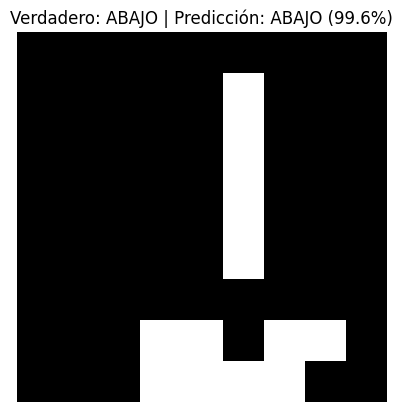

In [ ]:
def predict_and_show(idx=None):
    if idx is None:
        idx = np.random.randint(0, X_test.shape[0])
    x = X_test[idx]
    y_true = np.argmax(y_test[idx])
    probs = model.predict(x[np.newaxis, ...], verbose=0)[0]
    y_pred = int(np.argmax(probs))
    conf = float(np.max(probs))
    plt.imshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Verdadero: {labels[y_true]} | Predicción: {labels[y_pred]} ({conf*100:.1f}%)")
    plt.axis('off')
    plt.show()
    return y_true, y_pred, conf, probs

_ = predict_and_show()


##  Visualización de **filtros aprendidos** (kernels Conv2D)
- Mostramos los pesos del **primer** Conv2D.
- Cada filtro es una matriz 3×3 que detecta un patrón local.

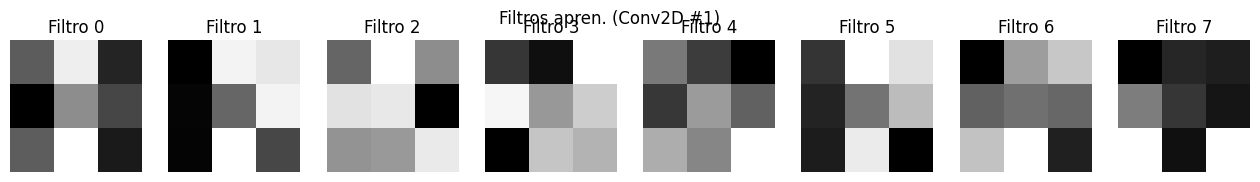

In [ ]:
first_conv = model.layers[0]
W, b = first_conv.get_weights()  # W: (3,3,1,8)
num_filters = W.shape[-1]
fig, axs = plt.subplots(1, num_filters, figsize=(2*num_filters, 2))
for i in range(num_filters):
    kernel = W[:, :, 0, i]
    axs[i].imshow(kernel, cmap='gray')
    axs[i].set_title(f"Filtro {i}")
    axs[i].axis('off')
plt.suptitle("Filtros apren. (Conv2D #1)")
plt.show()


Ejemplo: Clasificar una imagen específica

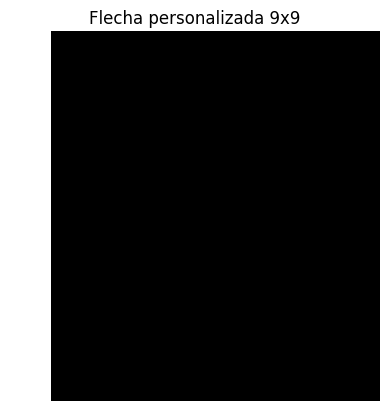

ARRIBA: 2.2%
ABAJO: 2.4%
IZQUIERDA: 94.5%
DERECHA: 0.9%

Predicción final: IZQUIERDA (94.5%)


In [ ]:

Mari = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0]
]

# Convert the list to a NumPy array
Mari = np.array(Mari)

plt.imshow(Mari, cmap='gray', vmin=0, vmax=1)
plt.title("Flecha personalizada 9x9")
plt.axis('off')
plt.show()

probs = model.predict(Mari[np.newaxis, ..., np.newaxis].astype(np.float32), verbose=0)[0]
pred = int(np.argmax(probs))
conf = float(np.max(probs))
for i, p in enumerate(probs):
    print(f"{labels[i]}: {p*100:.1f}%")
print(f"\nPredicción final: {labels[pred]} ({conf*100:.1f}%)")

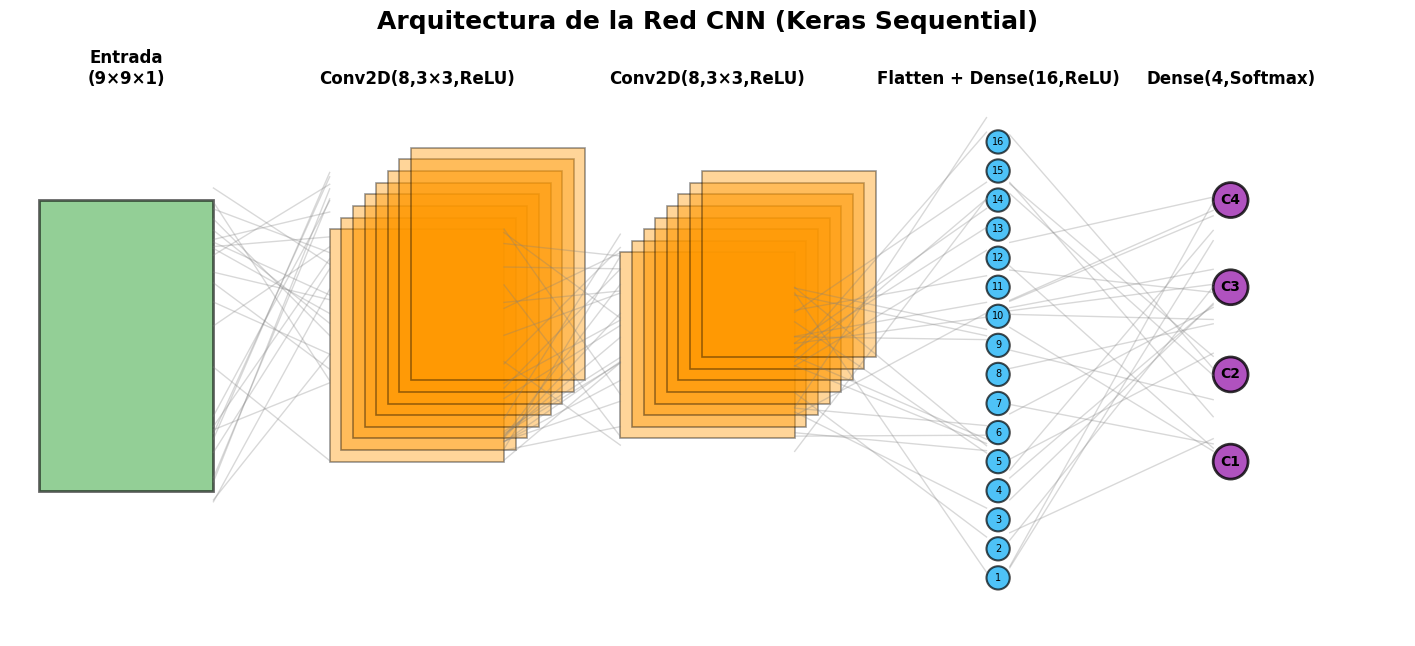

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np

# =============================================
# CONFIGURACIÓN DE LA FIGURA
# =============================================
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
ax.set_xlim(0, 24)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Arquitectura de la Red CNN (Keras Sequential)', fontsize=18, fontweight='bold', y=1.03)

# =============================================
# COLORES
# =============================================
input_color   = '#4CAF50'  # Verde
conv_color    = '#FF9800'  # Naranja
dense_color   = '#03A9F4'  # Azul
output_color  = '#9C27B0'  # Morado

# =============================================
# POSICIONES Y TAMAÑOS
# =============================================
x_positions = [2, 7, 12, 17, 21]  # Input, Conv1, Conv2, Dense, Output
layer_labels = [
    'Entrada\n(9×9×1)',
    'Conv2D(8,3×3,ReLU)',
    'Conv2D(8,3×3,ReLU)',
    'Flatten + Dense(16,ReLU)',
    'Dense(4,Softmax)'
]

# Alturas de cada bloque (para centrar)
def centered_y(h):
    return (10 - h)/2

# =============================================
# DIBUJO DE CAPAS
# =============================================
# 1) Capa de entrada (mapa 9x9)
input_rect = Rectangle((x_positions[0]-1.5, centered_y(5)), 3, 5,
                        ec='black', lw=2, fc=input_color, alpha=0.6)
ax.add_patch(input_rect)

# 2) Primer Conv2D (8 filtros)
for i in range(8):
    rect = Rectangle((x_positions[1]-1.5 + i*0.2, centered_y(4) + i*0.2), 3, 4,
                     ec='black', lw=1.2, fc=conv_color, alpha=0.4)
    ax.add_patch(rect)

# 3) Segundo Conv2D (8 filtros)
for i in range(8):
    rect = Rectangle((x_positions[2]-1.5 + i*0.2, centered_y(3.2) + i*0.2), 3, 3.2,
                     ec='black', lw=1.2, fc=conv_color, alpha=0.4)
    ax.add_patch(rect)

# 4) Flatten + Dense(16)
dense_positions = [(x_positions[3], 1 + i*0.5) for i in range(16)]
for i, pos in enumerate(dense_positions):
    circ = Circle(pos, 0.2, ec='black', lw=1.5, fc=dense_color, alpha=0.7)
    ax.add_patch(circ)
    ax.text(pos[0], pos[1], f'{i+1}', ha='center', va='center', fontsize=7, color='black')

# 5) Capa de salida (4 clases)
output_positions = [(x_positions[4], 3 + i*1.5) for i in range(4)]
for i, pos in enumerate(output_positions):
    circ = Circle(pos, 0.3, ec='black', lw=2, fc=output_color, alpha=0.8)
    ax.add_patch(circ)
    ax.text(pos[0], pos[1], f'C{i+1}', ha='center', va='center', fontsize=10, fontweight='bold')

# =============================================
# CONEXIONES
# =============================================
def connect_layers(start_x, end_x, y_start, y_end, n_lines=10):
    for _ in range(n_lines):
        y0 = np.random.uniform(*y_start)
        y1 = np.random.uniform(*y_end)
        ax.plot([start_x, end_x], [y0, y1], color='gray', alpha=0.3, lw=1)

# Entre capas
connect_layers(x_positions[0]+1.5, x_positions[1]-1.5, (2,8), (2,8), 25)
connect_layers(x_positions[1]+1.5, x_positions[2]-1.5, (3,7), (3,7), 25)
connect_layers(x_positions[2]+1.5, x_positions[3]-0.2, (3,6), (1,9), 25)
connect_layers(x_positions[3]+0.2, x_positions[4]-0.3, (1,9), (3,8), 25)

# =============================================
# ETIQUETAS
# =============================================
for x, label in zip(x_positions, layer_labels):
    ax.text(x, 9.5, label, fontsize=12, fontweight='bold', ha='center')

plt.show()


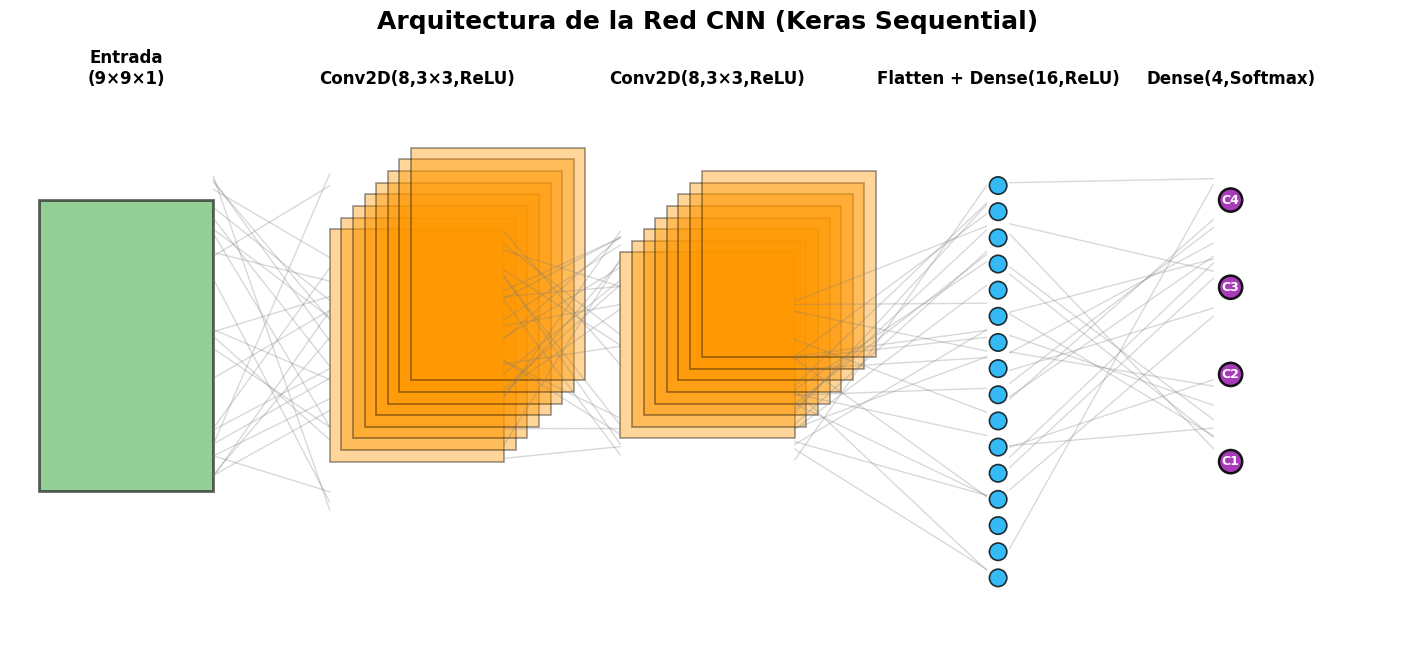